# Manual walk through of WEALTHAWK process

In [1]:
from scraping import ln_driver

import re
import urllib
import pandas as pd
import json
import matplotlib.pyplot as plt


In [2]:
linkedin = ln_driver() #custom linkedin driver using selinium webdriver

## Step 1: Find MIM events
Finding 'money-in-motion' events is pretty easy (but a bit pricy) for applications like aquisitions and IPOs and slightly harder for trust distributions and divorces. We manually downloaded a query of exits from our home market of San Diego from the last 3 years. This data isn't necessarily comrehensive but has a good percent of major deals. Can be aquired from crunchbase via snowflake or directly from pitchbook. Crunchbase deal is ~$10,000 per year. 

In [14]:
sd_exits = pd.read_csv('sd_exits.csv').iloc[:-2, :]
rel_columns = ['Company Name', "Primary Industry Group", "Deal Date", "Deal Size", "Deal Type", "Post Valuation", "% Acquired", "Investors", "Description", "Company Website", "Financing Status Note", "Deal Synopsis"]

In [16]:
sd_exits[rel_columns].head()

,Company Name,Primary Industry Group,Deal Date,Deal Size,Deal Type,Post Valuation,% Acquired,Investors,Description,Company Website,Financing Status Note,Deal Synopsis
0,Lytx,Software,08-Jan-2020,NaN,Buyout/LBO,"2,500.00",100.00%,Canada Pension Plan Investment Board(Geoff McK...,Developer of video telematics software for glo...,www.lytx.com,The company entered into a definitive agreemen...,The company entered into a definitive agreemen...
1,Ignyta,Pharmaceuticals and Biotechnology,07-Feb-2018,"1,800.00",Merger/Acquisition,"1,800.00",100.00%,Roche Holding (SWX: ROG)(Daniel O'Day),Ignyta is an oncology biotechnology company. I...,www.ignyta.com,The company was acquired by Roche (OTCQX: RHHB...,The company was acquired by Roche (OTCQX: RHHB...
2,BioMed Realty,Other Financial Services,20-Nov-2020,"14,600.00",Merger/Acquisition,"14,600.00",100.00%,NaN,Provider of real estate services to life scien...,www.biomedrealty.com,The company was acquired by existing undisclos...,The company was acquired by existing undisclos...
3,Bumble Bee Seafoods,Consumer Non-Durables,31-Jan-2020,928.00,Merger/Acquisition,928.00,100.00%,FCF Fishery(Max Chou),Provider and distributor of seafood products. ...,www.bumblebee.com,The company was acquired by FCF Fishery for $9...,The company was acquired by FCF Fishery for $9...
4,ECG Management Consultants,Healthcare Services,01-Nov-2019,300.00,Merger/Acquisition,300.00,100.00%,Siemens Healthineers (FRA: SHL)(Bernd Montag),Provider of healthcare management consulting s...,www.ecgmc.com,The company was acquired by Siemens Healthinee...,The company was acquired by Siemens Healthinee...


Let's check out the bioMed Realty exit.

In [36]:
deal_data = row_to_data(sd_exits.loc[2, :])
deal_data

{'company_name': 'BioMed Realty',
 'industry': 'Other Financial Services',
 'deal_amount': 14600000000.0,
 'deal_date': datetime.datetime(2020, 11, 20, 0, 0),
 'deal_type': 'Merger/Acquisition',
 'company_desc': 'Provider of real estate services to life science and technology community. The company operates as a real estate investment trust providing sustainable real estate solutions, which include development, construction, redevelopment, acquisition, financing, leasing, and property management, to tenant partners in the United States and the United Kingdom.',
 'deal desc': 'The company was acquired by existing undisclosed investors for $14.6 billion on November 20, 2020. As a part of the transaction, the company was recapitalized.'}

Normally all this data would be parsed directly into the database but I wanted to make it easy to read. So we can see that this company was aquiered for ~$14 billon in November of last year. This is a prime example of a MIM event. Lot's of people likely made a lot of money recently and are likely still in the market for financial advisors. Let's find out who works / worked for them. 

## Step 2: Find beneficiaries
Now that we've identified an event, we need to find who got wealthy from this event. For IPOs and aquisitions and other similar events, early and / or high ranking employees are likely going to have made a lot of money from the sale of the company so we want to find people who worked there and then estimate how much they might be worth.

In [41]:
employees = linkedin.find_current_empolyees(deal_data['company_name'], 1) #get the linkedin of people working here limiting to 10 people
employees

['https://www.linkedin.com/in/ian-thompson-cpa',
 'https://www.linkedin.com/in/connor-dryden-693810a3',
 'https://www.linkedin.com/in/philpatalano',
 'https://www.linkedin.com/in/jon-bergschneider-847b698',
 'https://www.linkedin.com/in/david-h-3084807',
 'https://www.linkedin.com/in/jmoshy',
 'https://www.linkedin.com/in/timothy-schoen-1219778',
 'https://www.linkedin.com/in/alex-stimpfl-414a2ab0',
 'https://www.linkedin.com/in/gourdikian',
 'https://www.linkedin.com/in/kaifrankville']

We now have the linkedin accounts of some people who worked / work at BioMed realty. Let's find some more information on them. We are currently using a scraping service called phantombuster to scrape linkedin profile data although we are looking into other options as well. This part ins't automated yet so for now we are just going to upload data.

In [118]:
#downloaded from phantombuster. working on automating this.
employee_table = pd.read_csv('example_data/result.csv').iloc[2:, :]
employee_json_list = parse_json('example_data/result.json')[2:]
#the fist two are just me from a previous trial.

In [119]:
employee_table.head()

,linkedinProfile,email,description,headline,location,imgUrl,firstName,lastName,fullName,subscribers,...,baseUrl,profileId,timestamp,connectionDegree,mutualConnectionsCount,mailFromDropcontact,qualificationFromDropContact,civilityFromDropContact,schoolDescription,birthday
2,https://www.linkedin.com/in/ian-thompson-cpa/,ian.thompson@biomedrealty.com,NaN,Senior Manager | USC Marshall MBA Candidate,"San Diego County, California, United States",https://media-exp1.licdn.com/dms/image/C5603AQ...,Ian,"Thompson, CPA","Ian Thompson, CPA",1062,...,https://www.linkedin.com/in/ian-thompson-cpa,ian-thompson-cpa,2021-03-12T22:21:20.819Z,2nd,1.0,ian.thompson@biomedrealty.com,catch-all@pro,Mr,NaN,NaN
3,https://www.linkedin.com/in/connor-dryden-6938...,connor.dryden@biomedrealty.com,NaN,"Senior Analyst, Finance at BioMed Realty","San Diego, California, United States",https://media-exp1.licdn.com/dms/image/C5603AQ...,Connor,Dryden,Connor Dryden,227,...,https://www.linkedin.com/in/connor-dryden-6938...,connor-dryden-693810a3,2021-03-12T22:21:39.418Z,2nd,1.0,connor.dryden@biomedrealty.com,catch-all@pro,Mr,Minor in Business,NaN
4,https://www.linkedin.com/in/philpatalano/,phil.patalano@biomedrealty.com,NaN,Analyst at BioMed Realty,"San Diego, California, United States",https://media-exp1.licdn.com/dms/image/C5603AQ...,Phil,Patalano,Phil Patalano,695,...,https://www.linkedin.com/in/philpatalano,philpatalano,2021-03-12T22:22:15.133Z,2nd,NaN,phil.patalano@biomedrealty.com,catch-all@pro,Mr,NaN,June 28
5,https://www.linkedin.com/in/jon-bergschneider-...,jon.bergschneider@biomedrealty.com,NaN,"Executive Vice President, Chief Development Of...","San Francisco, California, United States",NaN,Jon,Bergschneider,Jon Bergschneider,596,...,https://www.linkedin.com/in/jon-bergschneider-...,jon-bergschneider-847b698,2021-03-12T22:22:30.125Z,3rd,NaN,jon.bergschneider@biomedrealty.com,catch-all@pro,Mr,NaN,NaN
6,https://www.linkedin.com/in/david-h-3084807/,NaN,Management Characteristics:\n\nInnovative Info...,"Vice President, Information Technology at BioM...","San Diego County, California, United States",https://media-exp1.licdn.com/dms/image/C5603AQ...,David,H.,David H.,1271,...,https://www.linkedin.com/in/david-h-3084807,david-h-3084807,2021-03-12T22:23:03.314Z,3rd,NaN,NaN,NaN,Mr,Computer Science and Engineering - Programmi...,NaN


### Example data
These are the columns we have for each lead in the main table and below is a a json of the additional employment info and other fields we scraped. 

In [128]:
for x in employee_table.columns:
    print(x)

linkedinProfile
email
description
headline
location
imgUrl
firstName
lastName
fullName
subscribers
vmid
savedImg
linkedinSalesNavigatorUrl
connectionsCount
connectionsUrl
mutualConnectionsUrl
company
companyUrl
jobTitle
jobDescription
jobLocation
jobDateRange
company2
companyUrl2
jobTitle2
jobDescription2
jobLocation2
jobDateRange2
school
schoolUrl
schoolDegree
schoolDegreeSpec
schoolDateRange
school2
schoolUrl2
schoolDegree2
schoolDegreeSpec2
schoolDateRange2
websiteFromDropContact
website
companyWebsite
allSkills
skill1
endorsement1
skill2
endorsement2
skill3
endorsement3
skill4
endorsement4
skill5
endorsement5
skill6
endorsement6
baseUrl
profileId
timestamp
connectionDegree
mutualConnectionsCount
mailFromDropcontact
qualificationFromDropContact
civilityFromDropContact
schoolDescription
birthday


In [181]:
employee_json_list[0]

{'general': {'imgUrl': 'https://media-exp1.licdn.com/dms/image/C5603AQG3XqkP8vxfvg/profile-displayphoto-shrink_800_800/0/1564855856494?e=1620864000&v=beta&t=_BmtLioTrWdk834FkfoY-pDTI-OMRO9DjWmgFNT7VrM',
  'fullName': 'Ian Thompson, CPA',
  'company': 'BioMed Realty',
  'school': 'University of Southern California',
  'location': 'San Diego County, California, United States',
  'connections': '500+ connections',
  'profileUrl': 'https://www.linkedin.com/in/ian-thompson-cpa/',
  'connectionsCount': 500,
  'connectionDegree': '2nd',
  'mutualConnectionsUrl': 'https://www.linkedin.com/search/results/people/?facetNetwork=%5B%22F%22%5D&facetConnectionOf=%5B%22ACoAAALEhyIBqM-yDGQiAtrrHZ3eqwIIbVQdKhU%22%5D&origin=MEMBER_PROFILE_CANNED_SEARCH&RESULT_TYPE=PEOPLE',
  'mutualConnectionsCount': 1,
  'description': '',
  'firstName': 'Ian',
  'lastName': 'Thompson, CPA',
  'headline': 'Senior Manager | USC Marshall MBA Candidate',
  'vmid': 'ACoAAALEhyIBqM-yDGQiAtrrHZ3eqwIIbVQdKhU',
  'linkedinSales

Now that we have all this data let's look at some of the people we identified and filter who might be a good fit for northern trust wealth management:

Name:  Ian Thompson, CPA
Location:  San Diego County, California, United States
Contact info:

ian.thompson@biomedrealty.com
+1 206-508-6646


,company_name,url,job_title,start_date,end_date,location,description,time_spend
0,BioMed Realty,https://www.linkedin.com/company/biomed-realty/,Senior Manager,2020-12-01,2021-03-14 22:37:41.449756,"San Diego, California",review investment committee presentations lend...,103 days 22:37:41.449756
1,BioMed Realty,https://www.linkedin.com/company/biomed-realty/,"Senior Analyst, Financial Reporting",2015-12-01,2018-12-01 00:00:00.000000,Greater San Diego Area,performed technical accounting research and au...,1096 days 00:00:00
2,BioMed Realty,https://www.linkedin.com/company/biomed-realty/,"Analyst, Financial Reporting",2013-07-01,2015-12-01 00:00:00.000000,Greater San Diego Area,assisted in the preparation of the companys ex...,883 days 00:00:00
3,"Lindsay & Brownell, LLP",https://www.linkedin.com/company/lindsay-&-bro...,Senior Audit Associate,2012-01-01,2013-07-01 00:00:00.000000,"La Jolla, CA",provided professional audit services to numero...,547 days 00:00:00
4,McGladrey & Pullen,https://www.linkedin.com/company/rsm-us-llp/,Audit Associate,2010-10-01,2011-07-01 00:00:00.000000,None,delivered audit and accounting services to pri...,273 days 00:00:00


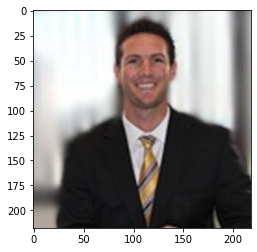

In [200]:
show_employee(employee_json_list[0])

Name:  Connor Dryden
Location:  San Diego, California, United States
Contact info:

connor.dryden@biomedrealty.com
+1 206-508-6646


,company_name,url,job_title,start_date,end_date,location,description,time_spend
0,BioMed Realty,https://www.linkedin.com/company/biomed-realty/,"Senior Analyst, Finance",2020-01-01,2021-03-14 22:37:48.567437,None,No job description,438 days 22:37:48.567437
1,BioMed Realty,https://www.linkedin.com/company/biomed-realty/,"Analyst, Finance",2018-08-01,2020-01-01 00:00:00.000000,None,No job description,518 days 00:00:00
2,Jack in the Box,https://www.linkedin.com/company/jack-in-the-box/,Financial Analyst,2016-10-01,2018-08-01 00:00:00.000000,San Diego,No job description,669 days 00:00:00
3,RoundWorld Solutions,https://www.linkedin.com/company/roundworld-so...,Business Analyst Intern,2016-01-01,2016-02-01 00:00:00.000000,Encinitas,No job description,31 days 00:00:00
4,Cornerstone Wealth Management,https://www.linkedin.com/company/cornerstone-w...,Investment Analyst Intern,2015-06-01,2015-09-01 00:00:00.000000,Rancho Bernardo,No job description,92 days 00:00:00
5,Silver Portal Capital,https://www.linkedin.com/company/silverportalc...,Capital Markets Intern,2014-06-01,2014-09-01 00:00:00.000000,San Diego,No job description,92 days 00:00:00


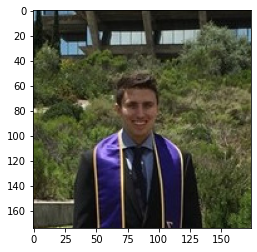

In [201]:
show_employee(employee_json_list[1])

Name:  Phil Patalano
Location:  San Diego, California, United States
Contact info:

phil.patalano@biomedrealty.com
+1 206-508-6646


,company_name,url,job_title,start_date,end_date,location,description,time_spend
0,BioMed Realty,https://www.linkedin.com/company/biomed-realty/,Analyst,2019-08-01,2021-03-14 22:37:52.237927,San Diego,No job description,591 days 22:37:52.237927
1,Deloitte,https://www.linkedin.com/company/deloitte/,Audit Senior,2018-08-01,2019-08-01 00:00:00.000000,Greater San Diego Area,currently working in the san diego marketplace...,365 days 00:00:00
2,Deloitte,https://www.linkedin.com/company/deloitte/,Senior Audit Assistant,2016-10-01,2018-08-01 00:00:00.000000,Greater San Diego Area,primarily served publicly traded energy relate...,669 days 00:00:00
3,Jack in the Box,https://www.linkedin.com/company/jack-in-the-box/,Corporate Income Tax Intern,2015-01-01,2016-09-01 00:00:00.000000,Greater San Diego Area,assisted in the preparation of the income tax ...,609 days 00:00:00
4,Deloitte,https://www.linkedin.com/company/deloitte/,Audit Intern,2015-06-01,2015-08-01 00:00:00.000000,Greater San Diego Area,performed testing and analytical procedures to...,61 days 00:00:00
5,Point Loma Nazarene University,https://www.linkedin.com/company/point-loma-na...,Resident Assistant,2014-08-01,2015-05-01 00:00:00.000000,Greater San Diego Area,provided support to students in residential ha...,273 days 00:00:00
6,Point Loma Nazarene University,https://www.linkedin.com/company/point-loma-na...,Church Relations Student Supervisor,2014-05-01,2014-09-01 00:00:00.000000,None,managed student interns and workers oversaw co...,123 days 00:00:00
7,Point Loma Nazarene University,https://www.linkedin.com/company/point-loma-na...,Sodexo Student Manager,2013-08-01,2014-05-01 00:00:00.000000,Greater San Diego Area,oversaw and managed student workers implementi...,273 days 00:00:00


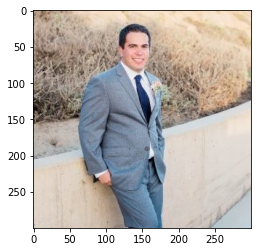

In [202]:
show_employee(employee_json_list[2])

This is a good sampling of employees. The first person, Ian Thompson, is likeley a very good canidite for at least the loser levels of the wealth managment buinsess. He's high ranking and he has been at the company since 2013 which means he's very likley to have made a lot of equity. He's also local to San Diego which is always good to double check.

Our second query, Connor Dryden, is slightly less appealing to the wealth managment branch but could still be work looking into. He's held reasonable positions at BioMed realty but he's only been there two years pre-exit so it likely to have made a lot less. 

Phil Patalano is probably not a good lead. He's been working as an analyist for about a year pre-exit which is unlikeley to accrue any major wealth. 


Once the product is built, this analysis will be done by artifical intelligence and not manually. 


That's pretty much the whole lead generation pipeline. We also plan to incorporate lead tracking as an additional service which will allow users in the same office to coordinate approhes and track outreach for an overall smoother process but that's largly seperate from the lead generation side. 

The major hurdle is simply automating this process. It's already largly automated we just need to figure out how to move the data quickly and at scale and how to keep collecting data from linkedin without them blocking us or slowing down the data collection signifigantly. 



### ------------------------------------ Ignore below this line -------------------------------------------
I just wrote some util functions down here to keep everything clean but you don't need to worry about these. 

In [199]:
def row_to_data(row):
    name = row['Company Name']
    industry = row['Primary Industry Group']
    deal_amount = float(row['Deal Size'].split('.')[0].replace(',',''))*1000000
    dt = datetime.strptime(row['Deal Date'], '%d-%b-%Y')
    deal_type = row['Deal Type']
    comp_desc = row['Description']
    deal_info = row['Deal Synopsis']
    
    dic = {"company_name": name,
           'industry': industry,
           'deal_amount': deal_amount,
           'deal_date': dt,
           'deal_type':deal_type,
           'company_desc': comp_desc,
           'deal desc': deal_info}
    return dic
    
def parse_json(filepath):
    '''
    phantombuster has a weird format for json file that looks like a python list of dicts so this just parses
    to an actual array of jsons.
    '''
    data = open('example_data/result.json').read()
    arr = data.split('},{"general"')
    arr[0] = arr[0][1:] + '}'
    arr[-1] = '{"general"' + arr[-1][:-2]
    jsonable = ['{"general"' + x + '}' for x in arr[1:-1]]
    jsonable = [arr[0]] + jsonable + [arr[-1]]
    for x in jsonable:
        try:
            json.loads(x)
        except:
            print(x)
    jsons = [json.loads(x) for x in jsonable]
    return jsons

def jobs_to_table(json_data):
    jobs = json_data['jobs']
    company_name, company_url, job_title, start_date, end_date, location, description = [], [], [],[], [], [],[]
    for x in jobs:
        company_name.append(x['companyName'])
        company_url.append(x['companyUrl'])
        job_title.append(x['jobTitle'])
        start,end = x['dateRange'].split('–')
        start_date.append(datetime.strptime(start.replace(' ', ''),'%b%Y'))
        if 'Present' in end:
            end = datetime.now()
        else:
            end = datetime.strptime(end.replace(" ", '') ,'%b%Y')
        end_date.append(end)
        location.append(x['location'])
        if x['description']:
            cleaned_desc = re.sub(r'[^A-Za-z0-9 ]+', '', x['description'].lower())
        else:
            cleaned_desc = 'No job description'
        description.append(cleaned_desc)
    
    data =  pd.DataFrame(data={"company_name":company_name,
                               "url": company_url,
                               "job_title": job_title,
                               "start_date":start_date,
                               "end_date" : end_date,
                               "location" : location,
                               "description": description})
    data['time_spend'] = data['end_date'] - data['start_date']
    return data

def show_employee(data):
    try:
        pic = urllib.request.urlopen(data['general']['imgUrl'])
        im = plt.imread(pic,0)
        plt.imshow(im)
    except:
        print("No image available")
    print("Name: ", data['general']['fullName'])
    print("Location: ", data['general']['location'])
    print('Contact info:\n')
    print(data['dropcontact']['email'])
    print(data['dropcontact']['phone'])
    return jobs_to_table(data)
    

In [197]:
employee_json_list[0]['dropcontact']

{'email': 'ian.thompson@biomedrealty.com',
 'qualification': 'catch-all@pro',
 'civility': 'Mr',
 'company': 'Biomed Realty',
 'company_linkedin': 'www.linkedin.com/company/137572',
 'first_name': 'Ian',
 'full_name': 'Ian Thompson, Cpa',
 'last_name': 'Thompson',
 'linkedin': 'www.linkedin.com/in/ian-thompson-cpa-6aa67313',
 'phone': '+1 206-508-6646',
 'website': 'www.biomedrealty.com'}